In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [9]:
def graphene_magnetic_ribbon(parameters): #for now it's just bearded
    '''
    Returns the Hamiltonian for a ribbon 
    geometry with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 3/2 (from t = 1 and v_f = 3/2(t*a/hbar))
    -parameters: dict
    Returns
    -H: numpy matrix of size 4*width-2+bottom_bearded+top_bearded
    '''
    #The parameters dictionary must have the following key,value pairs
    width = parameters['width']       #int Number of lattice unit cells in y direction. Each cell contains 4 sites and it is 3a long
    kx = parameters['kx']*np.sqrt(3)             # float in (-pi/pi] wavenumber in x direction. The sqrt(3) is because the y-direction lattice site is sqrt(3)a long
    bottom_bearded = parameters['bottom_bearded'] #bool type of zigzag bc at the bottom
    top_bearded = parameters['top_bearded']       #bool type of zigzag bc at the top
    mag_field = parameters['mag_field']           #float magnetic field
    
    peierls_factor = -np.sqrt(3)/2*mag_field*3 #The 3 is because the y-direction lattice site is 3a long

    hamiltonian = np.zeros((4*width-2+bottom_bearded+top_bearded,4*width-2+bottom_bearded+top_bearded),dtype = complex)

    def index(orbital,y):
        return orbital + 4*y-1+bottom_bearded
    ### We have 4 orbitals
    for y in range(width):
        if y!=0 or bottom_bearded:
            hamiltonian[index(0,y),index(1,y)] = -1
            hamiltonian[index(1,y),index(0,y)] = -1
        
        hamiltonian[index(1,y),index(2,y)] = -1*np.exp(1j*peierls_factor*(y-width/2)) - np.exp(-1j*kx)*np.exp(-1j*peierls_factor*(y-width/2))
        hamiltonian[index(2,y),index(1,y)] = -1*np.exp(-1j*peierls_factor*(y-width/2)) - np.exp(1j*kx)*np.exp(1j*peierls_factor*(y-width/2))

        if y!=width-1 or top_bearded:
            hamiltonian[index(2,y),index(3,y)] = -1
            hamiltonian[index(3,y),index(2,y)] = -1

        if y!=width-1:
            hamiltonian[index(3,y),index(0,y+1)] = -1*np.exp(-1j*peierls_factor*(y+0.5-width/2)) - np.exp(1j*kx)*np.exp(1j*peierls_factor*(y+0.5-width/2))
            hamiltonian[index(0,y+1),index(3,y)] = -1*np.exp(1j*peierls_factor*(y+0.5-width/2)) - np.exp(-1j*kx)*np.exp(-1j*peierls_factor*(y+0.5-width/2))

    return hamiltonian

In [10]:
parameters = {
    'width' : 150, # This is in units of 3a
    'bottom_bearded' : False,
    'top_bearded' : False,
    'mag_field' : 0.0015
             }
bands = []

for kx in np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),500):
    parameters['kx'] = kx
    hamiltonian = graphene_magnetic_ribbon(parameters)
    bands.append(np.sort(np.linalg.eigvalsh(hamiltonian)))
bands = np.array(bands)

(-1.8137993642342178, 1.8137993642342178)

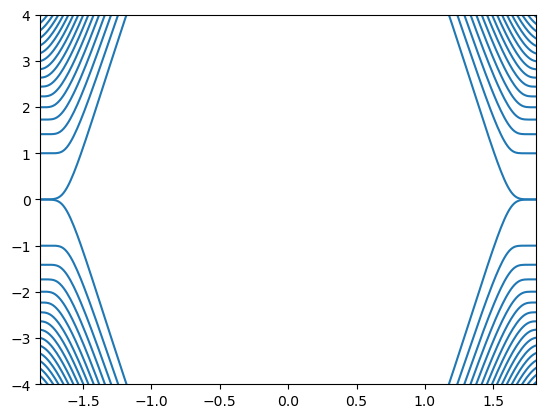

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
e1 = np.sqrt(2*parameters['mag_field'])*3/2 #The 3/2 is because the Fermi velocity is 2/3 in our units

for i in range(bands.shape[1]):
    #ax.plot(np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),len(bands[:,0])),bands[:,i]*3/2, c = 'C0')
    ax.plot(np.linspace(-pi,pi,len(bands[:,0])),bands[:,i]/e1, c = 'C0')

ax.set_ylim(-4,4)
#ax.set_xlim(-pi/np.sqrt(3),(-pi+2)/np.sqrt(3))
ax.set_xlim(-pi/np.sqrt(3),pi/np.sqrt(3))

###THE CONES ARE AT 2PI/(3*SQRT(3))

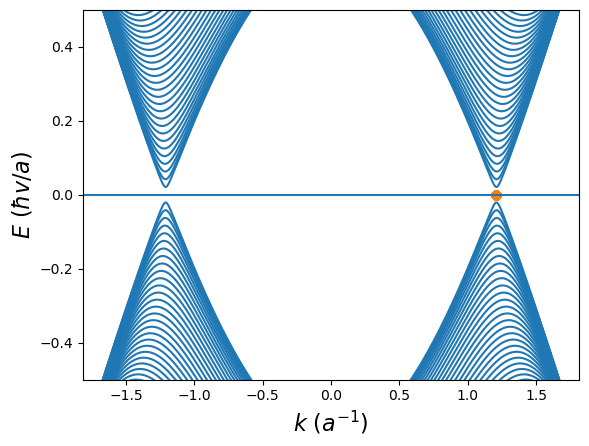

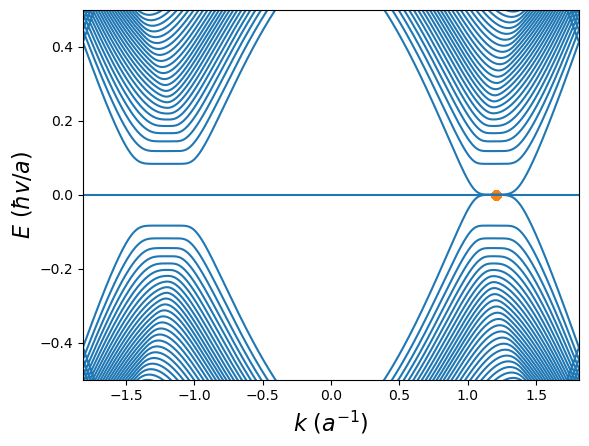

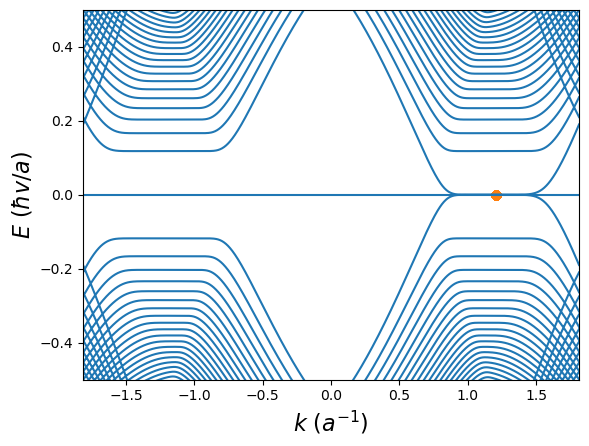

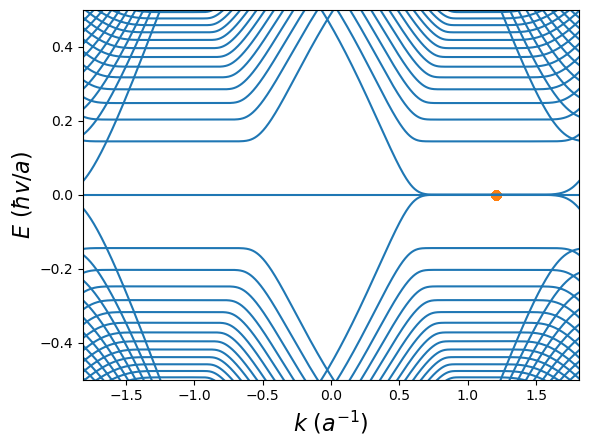

In [38]:
for mag_field in [x*0.0035 for x in range(4)]:
    parameters = {
    'width' : 50,
    'bottom_bearded' : False,
    'top_bearded' : True,
    'mag_field' : mag_field
             }
    bands = []
    
    for kx in np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),1000):
        parameters['kx'] = kx
        hamiltonian = graphene_magnetic_ribbon(parameters)
        bands.append(np.sort(np.linalg.eigvalsh(hamiltonian)))
    bands = np.array(bands)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)


    for i in range(bands.shape[1]):
        ax.plot(np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),len(bands[:,0])),bands[:,i]*(2/3), c = 'C0') ##Fermi velocity is 3/2
        ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 16)
        ax.set_xlim(-pi/np.sqrt(3),pi/np.sqrt(3))
        ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 16)
        
        ax.set_ylim(-0.5,0.5)
        ax.scatter([2*pi/3/np.sqrt(3)],[0], c = 'C1')

# Let us look at the eigenstates

We have to figure out a way to deak with the bearded and non-bearded cases

In [28]:
def graphene_bands(parameters,npoints):
    'Finds the spectrum of a graphene nanoribbon'
    bands = []
    momenta = np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),npoints)
    for kx in momenta:
        parameters['kx'] = kx
        hamiltonian = graphene_magnetic_ribbon(parameters)
        spectrum = np.linalg.eigvalsh(hamiltonian)
        bands.append(spectrum)
        #bands.append(spectrum[np.argsort(np.abs(spectrum))]) #Sorted by distance to E=0
    bands = np.array(bands)

    return momenta, bands

In [50]:
parameters = {
    'width' : 20, # This is in units of 3a
    'bottom_bearded' : True,
    'top_bearded' : True,
    'mag_field' : 0
             }
momenta, bands = graphene_bands(parameters,501)

(-1.8137993642342178, 1.8137993642342178)

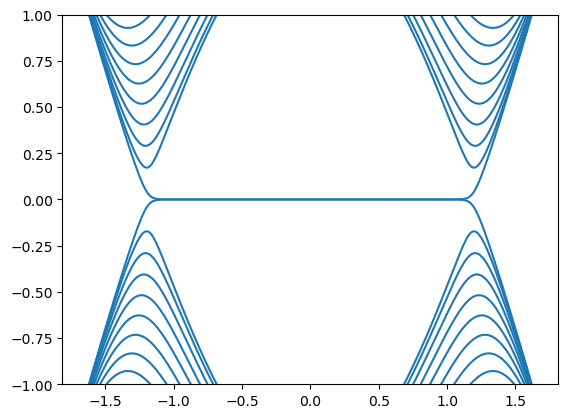

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
#e1 = np.sqrt(2*parameters['mag_field'])*3/2 #The 3/2 is because the Fermi velocity is 2/3 in our units

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i]*3/2, c = 'C0')

ax.set_ylim(-1,1)
ax.set_xlim(-pi/np.sqrt(3),pi/np.sqrt(3))

In [52]:
def graphene_states(parameters,kpoint):
    'Finds the an eigenstate of a graphene nanoribbon'
    parameters['kx'] = kpoint
    hamiltonian = graphene_magnetic_ribbon(parameters)
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)
    
    # If not bearded, we refill
    if not parameters['bottom_bearded']:
        eigenvectors = np.roll(np.concatenate((eigenvectors,np.zeros((4*parameters['width']-2+parameters['bottom_bearded']+parameters['top_bearded'],1))), axis = 1),1,axis = 1)
    if not parameters['top_bearded']:
        eigenvectors = np.concatenate((eigenvectors,np.zeros((4*parameters['width']-2+parameters['bottom_bearded']+parameters['top_bearded'],1))), axis = 1)
    
    # Reshape
    psi0 = eigenvectors[::4]
    psi1 = eigenvectors[1::4]
    psi2 = eigenvectors[2::4]
    psi3 = eigenvectors[3::4]
    eigenvectors = np.stack((psi0,psi1,psi2,psi3))
    
    order = np.argsort(np.abs(eigenvalues))  #Sorted by distance to E=0
    

    return eigenvalues[order], eigenvectors[:,:,order]

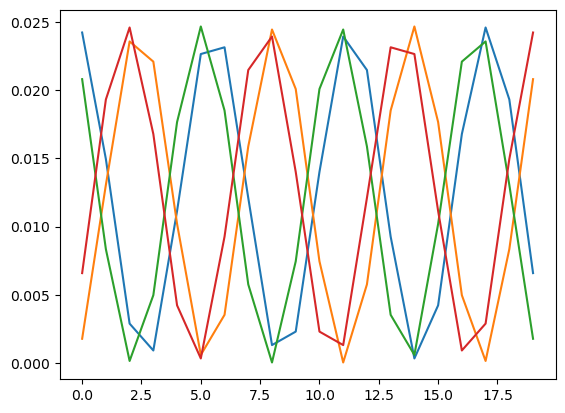

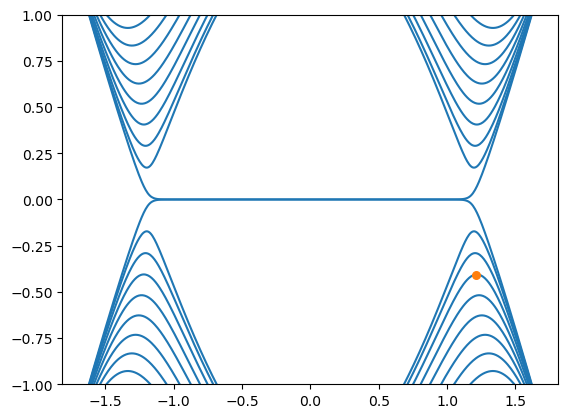

In [67]:
kplot = 2*pi/np.sqrt(3)/3
k_idx = (np.abs(momenta - kplot)).argmin()
state = 7

energies, psi = graphene_states(parameters,kplot)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.abs(psi[0,:,state])**2)
ax.plot(np.abs(psi[1,:,state])**2)
ax.plot(np.abs(psi[2,:,state])**2)
ax.plot(np.abs(psi[3,:,state])**2)

fig = plt.figure()
ax = fig.add_subplot(111)
#e1 = np.sqrt(2*parameters['mag_field'])*3/2 #The 3/2 is because the Fermi velocity is 2/3 in our units

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i]*3/2, c = 'C0')

ax.set_ylim(-1,1)
ax.set_xlim(-pi/np.sqrt(3),pi/np.sqrt(3))
k_idx = (np.abs(momenta - kplot)).argmin()
ax.scatter([momenta[k_idx]],[energies[state]*3/2], c= 'C1', s = 30,zorder = 2)

[-0.003634868465399288] [-2.996252346689761]


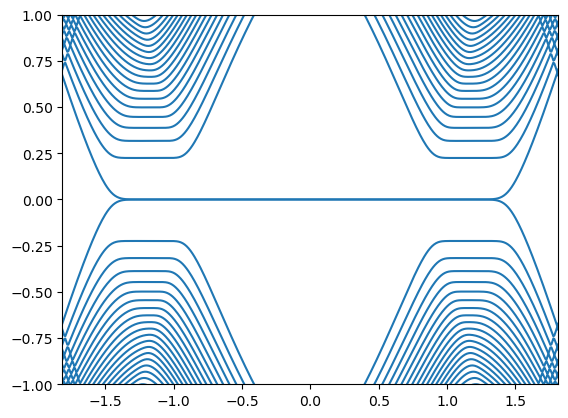

In [106]:
parameters = {
    'width' : 50, # This is in units of 3a
    'bottom_bearded' : True,
    'top_bearded' : True,
    'mag_field' : 0.005
             }

bands = []
momenta = np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),500)
for kx in momenta:
    parameters['kx'] = kx
    hamiltonian = graphene_magnetic_ribbon(parameters)
    bands.append(np.linalg.eigvalsh(hamiltonian))
bands = np.array(bands)

kspecial = 0#2*pi/3/np.sqrt(3)
k_idx = (np.abs(momenta - kspecial)).argmin()
state = 0


fig = plt.figure()
ax = fig.add_subplot(111)
e1 = np.sqrt(2*parameters['mag_field'])*3/2 #The 3/2 is because the Fermi velocity is 2/3 in our units

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i]*3/2, c = 'C0')

ax.set_ylim(-1,1)
ax.set_xlim(-pi/np.sqrt(3),pi/np.sqrt(3))

ax.scatter([momenta[k_idx]],[bands[k_idx,state]], c = 'C1')
print([momenta[k_idx]],[bands[k_idx,state]])



parameters['kx'] = k_point
hamiltonian = graphene_magnetic_ribbon(parameters)
eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)

# If not bearded, we refill
if not parameters['bottom_bearded']:
    eigenvectors = np.roll(np.concatenate((eigenvectors,np.zeros((4*parameters['width']-2+parameters['bottom_bearded']+parameters['top_bearded'],1))), axis = 1),1,axis = 1)
if not parameters['top_bearded']:
    eigenvectors = np.concatenate((eigenvectors,np.zeros((4*parameters['width']-2+parameters['bottom_bearded']+parameters['top_bearded'],1))), axis = 1)

# Reshape
psi0 = eigenvectors[::4]
psi1 = eigenvectors[1::4]
psi2 = eigenvectors[2::4]
psi3 = eigenvectors[3::4]

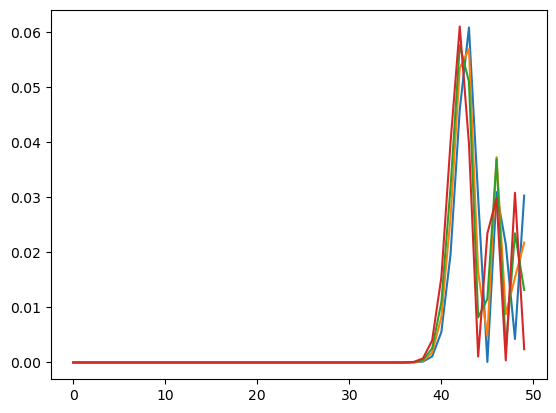

In [97]:
state = 2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.abs(psi0[:,state])**2)
ax.plot(np.abs(psi1[:,state])**2)
ax.plot(np.abs(psi2[:,state])**2)
ax.plot(np.abs(psi3[:,state])**2)

In [95]:
def graphene_magnetic_ribbon(parameters): #for now it's just bearded
    '''
    Returns the Hamiltonian for a ribbon 
    geometry with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 3/2 (from t = 1 and v_f = 3/2(t*a/hbar))
    -parameters: dict
    Returns
    -H: numpy matrix of size 4*width-2+bottom_bearded+top_bearded
    '''
    #The parameters dictionary must have the following key,value pairs
    width = parameters['width']       #int Number of lattice unit cells in y direction. Each cell contains 4 sites and it is 3a long
    kx = parameters['kx']*np.sqrt(3)             # float in (-pi/pi] wavenumber in x direction. The sqrt(3) is because the y-direction lattice site is sqrt(3)a long
    bottom_bearded = parameters['bottom_bearded'] #bool type of zigzag bc at the bottom
    top_bearded = parameters['top_bearded']       #bool type of zigzag bc at the top
    mag_field = parameters['mag_field']           #float magnetic field
    
    peierls_factor = -np.sqrt(3)/2*mag_field*3 #The 3 is because the y-direction lattice site is 3a long

    hamiltonian = np.zeros((4*width-2+bottom_bearded+top_bearded,4*width-2+bottom_bearded+top_bearded),dtype = complex)

    def index(orbital,y):
        return orbital + 4*y-1+bottom_bearded
    ### We have 4 orbitals
    for y in range(width):
        if y!=0 or bottom_bearded:
            hamiltonian[index(0,y),index(1,y)] = -1
            hamiltonian[index(1,y),index(0,y)] = -1
        
        hamiltonian[index(1,y),index(2,y)] = -1*np.exp(1j*peierls_factor*(y-width/2)) - np.exp(-1j*kx)*np.exp(-1j*peierls_factor*(y-width/2))
        hamiltonian[index(2,y),index(1,y)] = -1*np.exp(-1j*peierls_factor*(y-width/2)) - np.exp(1j*kx)*np.exp(1j*peierls_factor*(y-width/2))

        if y!=width-1 or top_bearded:
            hamiltonian[index(2,y),index(3,y)] = -1
            hamiltonian[index(3,y),index(2,y)] = -1

        if y!=width-1:
            hamiltonian[index(3,y),index(0,y+1)] = -1*np.exp(-1j*peierls_factor*(y+0.5-width/2)) - np.exp(1j*kx)*np.exp(1j*peierls_factor*(y+0.5-width/2))
            hamiltonian[index(0,y+1),index(3,y)] = -1*np.exp(1j*peierls_factor*(y+0.5-width/2)) - np.exp(-1j*kx)*np.exp(-1j*peierls_factor*(y+0.5-width/2))

    return hamiltonian

def graphene_bands(parameters,npoints):
    '''
    Finds the spectrum of a graphene nanoribbon
    with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 3/2 (from t = 1 and v_f = 3/2(t*a/hbar))
    -parameters: dict
    -npoints: int number of points calculated
    Returns
    -momenta: numpy array of size npoints
    -bands: numpy matrix of size 4*width-2+bottom_bearded+top_bearded, npoints
    '''
    bands = []
    momenta = np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),npoints)
    for kx in momenta:
        parameters['kx'] = kx
        hamiltonian = graphene_magnetic_ribbon(parameters)
        spectrum = np.linalg.eigvalsh(hamiltonian)
        bands.append(spectrum)
        #bands.append(spectrum[np.argsort(np.abs(spectrum))]) #Sorted by distance to E=0
    bands = np.array(bands)

    return momenta, bands

def graphene_states(parameters,kpoint):
    '''Finds the an eigenstate of a graphene nanoribbon
    with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 3/2 (from t = 1 and v_f = 3/2(t*a/hbar))
    -parameters: dict
    -kpoint: float wavenumber in x direction
    Returns
    -eigenvalues: numpy array of size 4*width-2+bottom_bearded+top_bearded
    -eigenvalues: numpy tensor of size 4,width,4*width-2+bottom_bearded+top_bearded'''
    parameters['kx'] = kpoint
    hamiltonian = graphene_magnetic_ribbon(parameters)
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)
    
    # If not bearded, we refill
    if not parameters['bottom_bearded']:
        eigenvectors = np.roll(np.concatenate((eigenvectors,np.zeros((1,4*parameters['width']-2+parameters['bottom_bearded']+parameters['top_bearded']))), axis = 0),1,axis = 0)
    if not parameters['top_bearded']:
        eigenvectors = np.concatenate((eigenvectors,np.zeros((1,4*parameters['width']-2+parameters['bottom_bearded']+parameters['top_bearded']))), axis = 0)
    
    # Reshape
    psi0 = eigenvectors[::4]
    psi1 = eigenvectors[1::4]
    psi2 = eigenvectors[2::4]
    psi3 = eigenvectors[3::4]
    eigenvectors = np.stack((psi0,psi1,psi2,psi3))
    
    order = np.argsort(np.abs(eigenvalues))  #Sorted by distance to E=0
    

    return eigenvalues[order], eigenvectors[:,:,order]

check1
check2
(20, 78) (20, 78) (20, 78) (20, 78)


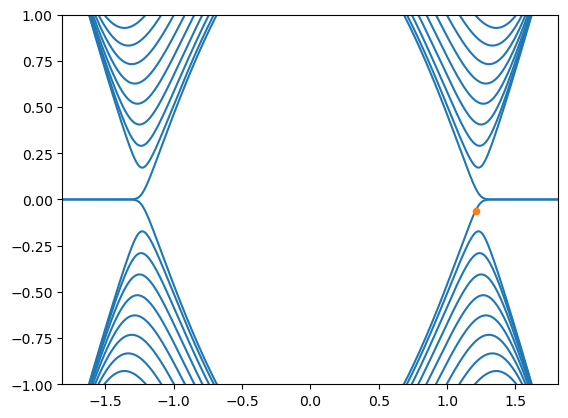

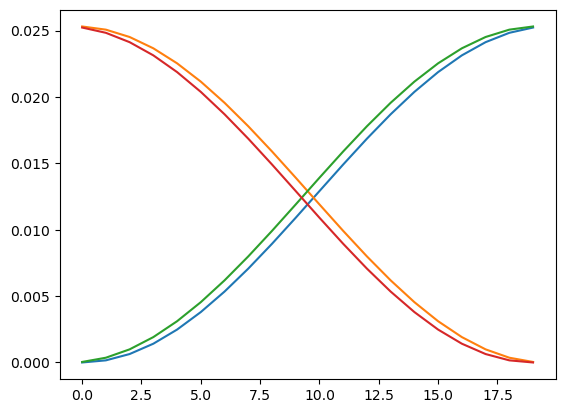

In [96]:
parameters = {
    'width' : 20, # This is in units of 3a
    'bottom_bearded' : False,
    'top_bearded' : False,
    'mag_field' : 0
             }
#Calculate bands
momenta, bands = graphene_bands(parameters, npoints = 501)

#Calculate eignestates at kplot and choose which one to plot.
kplot = 2*pi/np.sqrt(3)/3
k_idx = (np.abs(momenta - kplot)).argmin()
state = 0
energies, psi = graphene_states(parameters,kplot)

#Plot bands
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i]*3/2, c = 'C0')

ax.set_ylim(-1,1)
ax.set_xlim(-pi/np.sqrt(3),pi/np.sqrt(3))
k_idx = (np.abs(momenta - kplot)).argmin()
ax.scatter([momenta[k_idx]],[energies[state]*3/2], c= 'C1', s = 20,zorder = 2)

#Plot state
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.abs(psi[0,:,state])**2)
ax.plot(np.abs(psi[1,:,state])**2)
ax.plot(np.abs(psi[2,:,state])**2)
ax.plot(np.abs(psi[3,:,state])**2)

# Adding disorder

### We need to make an array of peierls_factor
peierls_factor appears in 4 places that can be independent. A first approach can be to just add a small contribution in each

In [23]:
######################################## GRAPHENE
def graphene_magnetic_ribbon(parameters):
    '''
    Returns the Hamiltonian for a ribbon 
    geometry with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    Returns
    -H: numpy matrix of size 4*width-2+bottom_bearded+top_bearded
    '''
    #The parameters dictionary must have the following key,value pairs
    width = parameters['width']       #int Number of lattice unit cells in y direction. Each cell contains 4 sites and it is 3a long
    kx = parameters['kx']*np.sqrt(3)             # float in (-pi/pi] wavenumber in x direction. The sqrt(3) is because the x-direction lattice site is sqrt(3)a long.
                                                 # This war parameters['k_x'] has units of 1/a
    bottom_bearded = parameters['bottom_bearded'] #bool type of zigzag bc at the bottom
    top_bearded = parameters['top_bearded']       #bool type of zigzag bc at the top
    mag_field = parameters['mag_field']           #float magnetic field
    noise = parameters['noise']       #int disorder strength
    np.random.seed(parameters['seed'])
    
    peierls_factor = np.sqrt(3)/2*mag_field*3 #The 3 is because the y-direction lattice site is 3a long

    hamiltonian = np.zeros((4*width-2+bottom_bearded+top_bearded,4*width-2+bottom_bearded+top_bearded),dtype = complex)

    def index(orbital,y):
        return orbital + 4*y-1+bottom_bearded
    ### We have 4 orbitals
    for y in range(width):
        if y!=0 or bottom_bearded:
            hamiltonian[index(0,y),index(1,y)] = -1
            hamiltonian[index(1,y),index(0,y)] = -1

        random_contribution = noise*(np.random.rand(1)[0]-0.5)
        hamiltonian[index(1,y),index(2,y)] = -1*np.exp(1j*peierls_factor*(y-width/2))*np.exp(1j*random_contribution) - np.exp(-1j*kx)*np.exp(-1j*peierls_factor*(y-width/2))*np.exp(-1j*random_contribution)
        hamiltonian[index(2,y),index(1,y)] = -1*np.exp(-1j*peierls_factor*(y-width/2))*np.exp(-1j*random_contribution) - np.exp(1j*kx)*np.exp(1j*peierls_factor*(y-width/2))*np.exp(1j*random_contribution)

        if y!=width-1 or top_bearded:
            hamiltonian[index(2,y),index(3,y)] = -1
            hamiltonian[index(3,y),index(2,y)] = -1

        if y!=width-1:
            random_contribution = noise*(np.random.rand(1)[0]-0.5)
            hamiltonian[index(3,y),index(0,y+1)] = -1*np.exp(-1j*peierls_factor*(y+0.5-width/2))*np.exp(-1j*random_contribution) - np.exp(1j*kx)*np.exp(1j*peierls_factor*(y+0.5-width/2))*np.exp(1j*random_contribution)
            hamiltonian[index(0,y+1),index(3,y)] = -1*np.exp(1j*peierls_factor*(y+0.5-width/2))*np.exp(1j*random_contribution) - np.exp(-1j*kx)*np.exp(-1j*peierls_factor*(y+0.5-width/2))*np.exp(-1j*random_contribution)

    return hamiltonian*2/3 #Adjusting units so that the fermi velocity is equal to 1

In [24]:
def graphene_bands(parameters,npoints):
    '''
    Finds the spectrum of a graphene nanoribbon
    with zigzag boundary conditions
    in a uniform magnetic field.
    In this case the units are given by a = 1 (y = 3a), hbar = 1, e = 1, v_F = 1
    -parameters: dict
    -npoints: int number of points calculated
    Returns
    -momenta: numpy array of size npoints
    -bands: numpy matrix of size 4*width-2+bottom_bearded+top_bearded, npoints
    '''
    bands = []
    momenta = np.linspace(-pi/np.sqrt(3),pi/np.sqrt(3),npoints)
    for kx in momenta:
        parameters['kx'] = kx
        hamiltonian = graphene_magnetic_ribbon(parameters)
        spectrum = np.linalg.eigvalsh(hamiltonian)
        bands.append(spectrum)
        #bands.append(spectrum[np.argsort(np.abs(spectrum))]) #Sorted by distance to E=0
    bands = np.array(bands)

    return momenta, bands

In [67]:
parameters = {
    'width' : 150, # This is in units of 3a
    'bottom_bearded' : False,
    'top_bearded' : False,
    'mag_field' : 0.0015,
    'noise' : 0.0015*10*3,
    'seed' : 0
             }
#Calculate bands
momenta, bands = graphene_bands(parameters, npoints = 501)


Text(0.5, 0, '$k_x\\,(a)$')

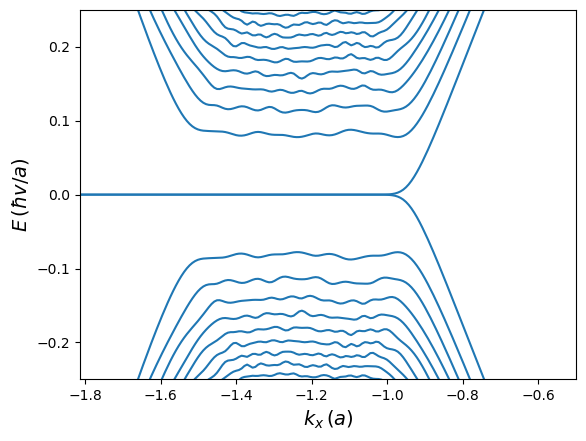

In [68]:
#Plot bands
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(bands.shape[1]):
    ax.plot(momenta,bands[:,i]*3/2, c = 'C0')

ax.set_ylim(-0.25,0.25)
ax.set_xlim(-pi/np.sqrt(3),-0.5)
ax.set_ylabel(r'$E\,(\hbar v/a)$',fontsize = 14)
ax.set_xlabel(r'$k_x\,(a)$',fontsize = 14)